In [26]:
import pandas as pd
import torch
import torch
import numpy as np
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from IPython.display import Image
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import openai

In [171]:
#!pip install apikey

In [76]:
from apikey import key

In [77]:
#Get OpenAI API KEY
openai.api_key= key

In [28]:
df=pd.read_csv("ratings.csv")

In [29]:
#For simplification we 
df=df.sample(10000)

In [30]:
#Define a custom movie dataset class
class MovieDataset(Dataset):
    def __init__(self, userId, movieId, rating):
        self.userId=userId
        self.movieId=movieId
        self.rating=rating

    def __len__(self):
        return len(self.userId)

    def __getitem__(self, item):
        userId=self.userId[item]
        movieId=self.movieId[item]
        rating=self.rating[item]
        return   torch.tensor(userId), torch.tensor(movieId),  torch.tensor(rating)

In [31]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)
#Split data into train and validate data:
train_set, test_set= train_test_split(df, test_size=0.1)

In [32]:
#Create torch datasets
train_dataset = MovieDataset(train_set.userId.values, train_set.movieId.values,train_set.rating.values)
test_dataset = MovieDataset(test_set.userId.values,test_set.movieId.values,test_set.rating.values)
train_loader = DataLoader(train_dataset , batch_size = 8)
test_loader = DataLoader(test_dataset, batch_size = 8)

 ## Neural Collaborative Filtering
 
 Here we use the framework suggested in the paper Neural collaborative filtering (2017) by He, X., Liao, L., Zhang, H., Nie, L., Hu, X., &amp; Chua, T.-S.0
 
 
 
![NCF](Illustration-of-a-Neural-Collaborative-Filtering-b-CCCFNet-c-Wide-Deep.png)


In [33]:
n_factors= 20
n_users=len(df.userId.unique())
n_items=len(df.movieId.unique())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self,  n_users, n_items, n_factors):
        super().__init__()
        # create vector embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_items, n_factors)
       # self.lin= torch.nn.Linear(n_factors*2,1)
        self.mlp = nn.Sequential(
            nn.Linear(n_factors*2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),  # Additional hidden layer
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, user, movie):
        # matrix multiplication
        user_embedding=self.user_factors(user)
        movie_embedding=self.movie_factors(movie)
        x=torch.cat((user_embedding, movie_embedding), dim=1)

        return self.mlp(x).view(-1)

In [35]:
# Training Function
def train(num_epochs):
    best_accuracy = 0.0
    
    print("Begin training...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_vall_loss = 0.0
        train_loss=0.0
        total = 0
        # Training Loop
        for (user,movie, rating)  in tqdm(train_loader, desc="Processing"):
            # Make predictions for this batch
            user, movie, rating= user.cuda(), movie.cuda(), rating.cuda()
            optimizer.zero_grad()
            outputs = model(user,movie).view(-1)
            loss = loss_fn(outputs, rating.float())
            loss.backward()   # backpropagate the loss
            optimizer.step()        # adjust parameters based on the calculated gradients
            running_train_loss +=loss.item() # track the loss value
            # Calculate training loss value
            train_loss_value = running_train_loss/len(train_loader)
            # Print the statistics of the epoch
        losses.append(train_loss_value)
        if(epoch%10 == 0):
            print('Batch', epoch, 'Training Loss is: %.4f' %train_loss_value)   


  
## Train the Model

In [36]:
num_epochs = 256
model = MatrixFactorization(n_users, n_items,n_factors)
model=model.to(device)
# MSE loss
loss_fn = torch.nn.MSELoss()
# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
losses = []  
model.train()

MatrixFactorization(
  (user_factors): Embedding(593, 20)
  (movie_factors): Embedding(3645, 20)
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [38]:
train(num_epochs)

Begin training...


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 10 Training Loss is: 0.4606


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 20 Training Loss is: 0.1400


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 30 Training Loss is: 0.0676


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 40 Training Loss is: 0.0591


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 50 Training Loss is: 0.0556


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 60 Training Loss is: 0.0507


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 70 Training Loss is: 0.0492


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 80 Training Loss is: 0.0356


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 90 Training Loss is: 0.0211


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 100 Training Loss is: 0.0261


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 110 Training Loss is: 0.0236


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 120 Training Loss is: 0.0225


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 130 Training Loss is: 0.0210


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 140 Training Loss is: 0.0173


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 150 Training Loss is: 0.0197


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 160 Training Loss is: 0.0185


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 170 Training Loss is: 0.0148


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 180 Training Loss is: 0.0135


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 190 Training Loss is: 0.0219


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 200 Training Loss is: 0.0141


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 210 Training Loss is: 0.0118


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 220 Training Loss is: 0.0134


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 230 Training Loss is: 0.0165


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 240 Training Loss is: 0.0128


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 250 Training Loss is: 0.0107


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

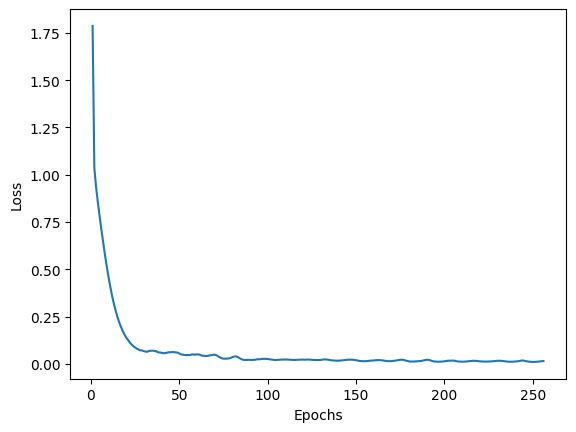

In [39]:
plt.plot(range(1, num_epochs+1), losses)
plt.ylabel('Loss')
plt.xlabel('Epochs');

## Prepare Test Data For Evaluation

We use Mean Absolute Error (MAE) for evaluation


In [40]:
# Set the model to evaluation mode
model.eval()

#Initiate values
total_loss = 0.0
num_samples = len(test_loader)

with torch.no_grad():
    for (user,movie, rating) in test_loader:
        user, movie, rating= user.cuda(), movie.cuda(), rating.cuda()
        outputs = model(user,movie).view(-1)
        mae = nn.L1Loss()
        loss = mae(outputs, rating) 
        total_loss += loss.item() 

print(f"MAE= {total_loss/num_samples}")


MAE= 0.9125858348608017


## Example Prediction

We will choose a random sample from test data to compare NCF with GPT

In [ ]:
#choosing a random sample
example_set=test_set.sample(10)

In [43]:
#Create example torch datasets
example_dataset = MovieDataset(example_set.userId.values, example_set.movieId.values, example_set.rating.values)
example_loader = DataLoader(example_dataset, batch_size = 8)

In [44]:
# Create a PrettyTable to store values
table = PrettyTable()
table.field_names = ["User ID", "Actual Rating", "Predicted Rating"]

# Set the model to evaluation mode
model.eval()

# Make predictions:
for (user,movie, rating)  in example_loader:
    
    with torch.no_grad():
        user, movie, rating= user.cuda(), movie.cuda(), rating.cuda()
        outputs = model(user,movie).view(-1)

    # Print input, target, and predicted values
    for i in range(len(rating)):
        userId=user[i].item()
        rating_value = rating[i].item()
        predicted_value = outputs[i].item()

        table.add_row([userId, rating_value, round(predicted_value*2,0)/2]) 


In [45]:
# Print the results
print(table)

+---------+---------------+------------------+
| User ID | Actual Rating | Predicted Rating |
+---------+---------------+------------------+
|   474   |      2.5      |       2.5        |
|    19   |      4.0      |       3.5        |
|   218   |      5.0      |       3.0        |
|   302   |      4.0      |       3.0        |
|   255   |      5.0      |       4.0        |
|   459   |      4.0      |       2.5        |
|   589   |      4.0      |       3.5        |
|   223   |      3.5      |       3.0        |
|   263   |      3.5      |       3.5        |
|   173   |      4.5      |       3.5        |
+---------+---------------+------------------+


## Using OpenAI's GPT to predict movie ratings

Since we used label encoding, now we need to get the original data to show it to GPT

In [46]:
#Get the original data
example_set.userId = lbl_user.inverse_transform(example_set.userId.values) 
example_set.movieId = lbl_movie.inverse_transform(example_set.movieId.values) 

In [47]:
#Get information about movies
movies=pd.read_csv("movies.csv")
target_data=example_set.merge(movies, how='left')

In [48]:
#Get the original train data:
train_set.userId = lbl_user.inverse_transform(train_set.userId.values) 
train_set.movieId = lbl_movie.inverse_transform(train_set.movieId.values) 
#Add information about the movies:
train_data= train_set[train_set.userId.isin(example_set.userId)].merge(movies)

In [78]:
#Get the rating based on prompts:
def get_rating(system_prompt, user_prompt):
    rating=openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature = 0.9,
        messages=[
                {"role":"system", "content": system_prompt},
                 {"role":"user", "content": user_prompt}
                    ]
                    )
    return(get_text(rating))
#Get value from GPT
def get_text(opneAI_object):
    text = list(opneAI_object.choices)[0]
    text=text.to_dict()['message']['content']
    return(text)

### Prompt Engineering and making predictions

In [122]:
users=train_data.userId.unique()
predicted_values=[]
for user in users:
    
    system_prompt="You are a movie expert, you predict a user's movie ratings from 1 to 5 by 0.5 increments based on thier previous ratings of different movies"
    df_user=train_data[train_data.userId==user]
    if len(df_user)>5:
        df_user=df_user.sample(5)
    for index, row in df_user.iterrows():
        genre=row['genres'].replace("|", " and ")
        target_genre=target_data[target_data.userId==user]['genres'].iloc[0].replace("|", " and ")
        target_movie=target_data[target_data.userId==user].iloc[0]['title']

        system_prompt=f"{system_prompt} I have rated the movie {row['title']} a rating of {row['rating']}/5.0, this movie is categorized as {genre}."
    user_prompt= f"What is the most likely rating I would give to the movie {target_movie}, it is categorized as {target_genre}, your response should be in the form of a numerical rating (from 1 to 5), keep your answer to one word."
    
    predicted_values.append(get_rating(system_prompt, user_prompt))


### Evaluate the results

In [162]:
target_data['Predicted Ratings']=predicted_values
target_data['Predicted Ratings']=target_data['Predicted Ratings'].astype(float)

In [ ]:
target_data=target_data[['userId', 'rating', 'Predicted Ratings']].rename(columns={'userId':"User ID", 'rating':"Actual Rating"}) 

In [165]:
target_data

,User ID,Actual Rating,Predicted Ratings
0,489,2.5,4.5
1,21,4.0,4.0
2,226,5.0,4.5
3,313,4.0,4.0
4,266,5.0,4.0
5,474,4.0,3.5
6,607,4.0,3.5
7,232,3.5,4.0
8,274,3.5,4.5
9,177,4.5,4.5


In [170]:
print(f"MAE= {abs(target_data['Actual Rating']-target_data['Predicted Ratings']).mean()}")

MAE= 0.6


We see that the MAE is much smaller, however this is only a small test sample and it might not reflect the true perfoemance of the method

## Compare Both Methods

In [143]:
table.add_column('GPT Rating',target_data['Predicted Ratings'].values)
table.field_names = ["User ID", "Actual Rating", "NCF Rating", "GPT Rating"]

In [144]:
print(table)

+---------+---------------+------------+------------+
| User ID | Actual Rating | NCF Rating | GPT Rating |
+---------+---------------+------------+------------+
|   474   |      2.5      |    2.5     |    4.5     |
|    19   |      4.0      |    3.5     |    4.0     |
|   218   |      5.0      |    3.0     |    4.5     |
|   302   |      4.0      |    3.0     |    4.0     |
|   255   |      5.0      |    4.0     |    4.0     |
|   459   |      4.0      |    2.5     |    3.5     |
|   589   |      4.0      |    3.5     |    3.5     |
|   223   |      3.5      |    3.0     |    4.0     |
|   263   |      3.5      |    3.5     |    4.5     |
|   173   |      4.5      |    3.5     |    4.5     |
+---------+---------------+------------+------------+
